## Garment Segmentation Preprocessing

### Introduction
The data being used is a smaller subset from our own photo studios over the years. The dataset itself consists of two types of images:
* The image shoot on the dressed mannequin
* The Photoshop generated cutout

The garments are shoot at 3 different viewpoints in our own custom rotating photo studio that automatically captures and processes 3 standard images for each garment. Namely Front, Front-Right and Back. Image viewpoints: 
<img src='./images/image_viewpoints.png'>


The segmentation dataset used here consists of 1084 raw garment images and an equivalent number of cutouts (masks). The resolution of the imagery is 1152x1728, the type is Portable Network Graphics (PNG) thereby using format: RGBA (byte-order). The combined size of the imagery is 1.1 GB.

The cutouts are created by our Indian team using Photoshop on the images shoot on the dressed mannequin. These cutouts are our ground truth and illustrated here:
<img src='./images/image_viewpoints_cutouts.png'>


### The Data



#### Counting and paring garment and cutouts

In [88]:
import glob

orig_img_path = "../input_CP/original/*.*"
cutout_img_path = "../input_CP/segmented/*.*"

orig_img_paths = sorted(glob.glob(orig_img_path))
seg_img_paths = sorted(glob.glob(cutout_img_path))     
    
print('There are %d original training images.' % len(orig_img_paths))
print('There are %d cutout training images.' % len(seg_img_paths))

print('Names of first original image: %s.' % orig_img_paths[0])
print('Names of first segmented image: %s.' % seg_img_paths[0])
print('Names of 1000th original image: %s.' % orig_img_paths[999])
print('Names of 1000th segmented image: %s.' % seg_img_paths[999])


There are 1084 original training images.
There are 1084 cutout training images.
Names of first original image: ../input_CP/original\0055dc41-cc2a-4572-8864-f1136c55de77_Back.png.
Names of first segmented image: ../input_CP/segmented\0055dc41-cc2a-4572-8864-f1136c55de77_Back.png.
Names of 1000th original image: ../input_CP/original\5b3d962d-a0bf-421c-a80b-d0bf2ba6fd64_FrontRight.png.
Names of 1000th segmented image: ../input_CP/segmented\5b3d962d-a0bf-421c-a80b-d0bf2ba6fd64_FrontRight.png.


Original images and cutout images are named uniquely and identically and therefore it will be safe to pair garments using the same index into both these lists. 

#### Generating the Alpha masks
The cutouts are no use in themselves. We need the binary masks within them to tell our NN if a pixel is garment or background, that is, a binary classification of a given pixel. 

Creating our Alpha masks from our cutouts (script here: util/cutouts_to_masks.py):

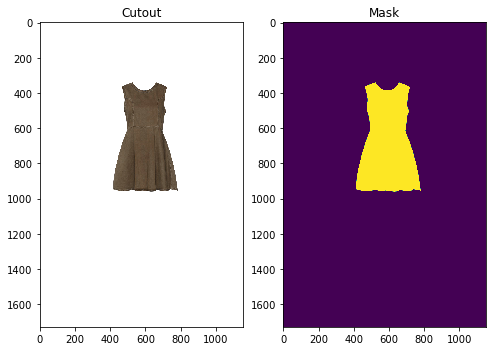

In [89]:
import cv2
from tqdm import tqdm, tqdm_notebook, tnrange
import numpy as np
from matplotlib import pyplot as plt

def turn_image_to_mask(cutout_image):
    """
        Extracts the Alpha mask from the supplied image. It is assumed that the 
        image format follows: (height, width, channels), ex: (1728, 1152, 4)
    """
    if cutout_image.shape[2] != 4:
        raise ValueError("image format must follows(height, width, channels) with channels = 4 (RGBA)")
    img_reshaped = np.moveaxis(cutout_image, 2, 0)
    mask = img_reshaped[3] # index of the alpha mask
    return mask


def cutouts_to_masks(seg_img_paths):
    """
        Extracts the Alpha masks from the supplied images contained in cutout_path location
    """
    cutouts = []
    masks = []
    for filepath in tqdm_notebook(seg_img_paths[0:30]): # I have reduced the number here for illustration purposes only
        cutout_image = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
        cutouts.append(cutout_image)
        cutout_mask = turn_image_to_mask(cutout_image)
        masks.append(cutout_mask)
    return cutouts, masks
            
cutouts, masks = cutouts_to_masks(seg_img_paths)

# Visualise it
fig = plt.figure(figsize=(8, 8))
        
imgplt = fig.add_subplot(1, 2, 1)
imgplt.set_title("Cutout")
plt.imshow(cutouts[22])

imgplt = fig.add_subplot(1, 2, 2)
imgplt.set_title("Mask")
plt.imshow(masks[22])

plt.show()

Note: We are now done with the cutouts, they only serve to generate the Alpha masks. Going forwards all masks will refer to the binary Alpha masks contained in the folder ./input_CP/masks.


### Basic Preprocessing

Basic preprocessing consists of the following steps:

1. Split the data into four parts: 
    * original image set for training
    * mask image set for training
    * original image set for validation
    * mask image set for validation
2. Load original garment images in color mode and masks in gray scale mode
3. Resize images into smaller sizes such that the GPU can handle our original image size with a performant model but also to accelerate the feedback loop in terms of what works and not, smaller sizes execute much faster 256 versus 1024 almost 6 times faster (for selected Unet model)
4. With TensorFlow as backend, Keras CNNs require a 4D tensor (array) as input, with shape (samples, rows, columns, channels) 
    * samples corresponds to the total number of images
    * rows, columns, and channels correspond to the number of rows, columns, and channels for each image, respectively.
5. Turning the image a array into a format that Keras can work with, that is, turn the [0, 255] array into a floating point array in the range [0, 1]

Note: It can be argued that I should randomise the imagery going into the various split datasets (train and valid). I could make use of train_test_split. The reason for not doing it is that I will be running a lot of experiments and in order to compare the results I always need to use the same split datasets and understand what is contained in each split.

In [340]:
import os
from keras.preprocessing import image                  
from skimage import exposure
    
# Fixed split of our intial dataset containg 1084 original garment images and 1084 binary masks.    
# Step 1
orig_train = file_img_paths[0:900]
seg_train = file_seg_paths[0:900] # Note: this is assumed to contain binary Alpha masks from the folder ./input_CP/masks
orig_valid = file_img_paths[900:]
seg_valid = file_seg_paths[900:]  # Note: this is assumed to contain binary Alpha masks from the folder ./input_CP/masks

def path_to_tensor(img_path, is_mask):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) if is_mask else cv2.imread(img_path) # Step 2
    img_scaled = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) # Step 3
    x = image.img_to_array(img_scaled) # Step 4
    x = np.expand_dims(x, axis=0) # Step 4
    return x

def paths_to_tensor(img_paths, is_mask):
    list_of_tensors = [path_to_tensor(img_path, is_mask) for img_path in tqdm_notebook(img_paths)]
    return np.vstack(list_of_tensors)

# Step 5
orig_train_tensors = paths_to_tensor(orig_train, False).astype('float32')/255
seg_train_tensors = paths_to_tensor(seg_train, True).astype('float32')/255
orig_valid_tensors = paths_to_tensor(orig_valid, False).astype('float32')/255
seg_valid_tensors = paths_to_tensor(seg_valid, True).astype('float32')/255

print('Shape of image training set: ' + str(orig_train_tensors.shape))
print('Shape of mask training set: ' + str(seg_train_tensors.shape))
print('Shape of image validation set: ' + str(orig_valid_tensors.shape))
print('Shape of mask validation set: ' + str(seg_valid_tensors.shape))



Shape of image training set: (900, 256, 256, 3)
Shape of mask training set: (900, 256, 256, 1)
Shape of image validation set: (184, 256, 256, 3)
Shape of mask validation set: (184, 256, 256, 1)


### Resizing imagery
Everytime we downsize as in step 3 above we should always use the cv2.INTER_AREA algorithm <BR>
- Downsize: cv2.resize(img, (input_size, input_size), interpolation=cv2.INTER_AREA)

and when upsizing we should always use the cv2.INTER_CUBIC algorithm
- Upsize: cv2.resize(img, (orig_width, orig_height), interpolation=cv2.INTER_CUBIC)

This should happend both when preparing the data for training but also when applying the predictor. The effect turns out to be significant. It turns out that using resizing interpolation-algorithms are easy and have one of the largest impacts on improving our performance. The improvement are of the order 0.1 - 0.2 of a percent for our imagery. 

Good reference here: http://tanbakuchi.com/posts/comparison-of-openv-interpolation-algorithms/


### Centering and Normalizing Image inputs
Basic preprocessing outlines the steps to prepare our data for feeding into out NN model and, depending on the model architecture, normally will converge reasonably fast and with good accuracy. However in our pursuit for faster convergence and higher accuracy we might be able to improve on all parameters by data normalization. Data normalization is an important step as it ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel, and then dividing the result by the standard deviation. The distribution of such data would resemble a normal distribution.

Below code seeks to visualise the mean and standard deviation. Observing this could give us insight into some underlying structure in the images. In this case we see a loose impression of a garment on a mannequin, center aligned and of comparable size. We may choose to augment our data with perturbed images if we don’t want our input data to have this innate structure. The standard deviation of all images is shown to the right. Higher variance values show up whiter, so we see that the pictures vary a lot at the boundaries compared to the center, that is true for both the photo studio setup as well as for the garments.

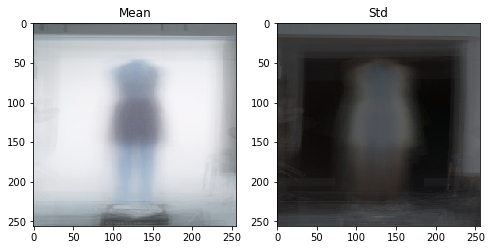

In [341]:
"""
Calculate the mean and std for each pixel
"""
orig_mean = orig_train_tensors.mean(axis=(0), keepdims=True)
orig_std = orig_train_tensors.std(axis=(0), keepdims=True)

orig_train_tensors -= orig_mean # center
orig_train_tensors /= orig_std # normalize

orig_valid_tensors -= orig_mean # center
orig_valid_tensors /= orig_std # normalize


# Visualise it
dataset_mean = np.squeeze(orig_mean, axis=(0)) # (1, 256, 256, 3) --> (256, 256, 3)
dataset_std = np.squeeze(orig_std, axis=(0))
    
fig = plt.figure(figsize=(8, 8))
        
imgplt = fig.add_subplot(1, 2, 1)
imgplt.set_title("Mean")
plt.imshow(dataset_mean)

imgplt = fig.add_subplot(1, 2, 2)
imgplt.set_title("Std")
plt.imshow(dataset_std)

plt.show()    
    

Note: Going forwards when I refer to normalised data I mean input data that is both centered and normalised.

Below code illustrates how our input data are being modified as part of the normalization. It is clearly illustrated how the distribution of such data would resemble a zero centeret Gaussian curve. To recap: mean subtraction per channel are used to center the data around zero mean for each channel (R, G, B). The reason we do these things is because in the process of training our network, we're going to be multiplying (weights) and adding to (biases) these initial inputs in order to cause activations that we then backpropogate with the gradients to train the model.

We'd like in this process for each feature to have a similar range so that our gradients don't go out of control (and that we only need one global learning rate multiplier).

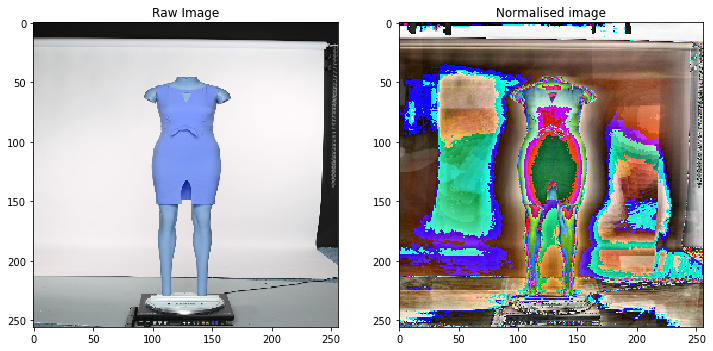

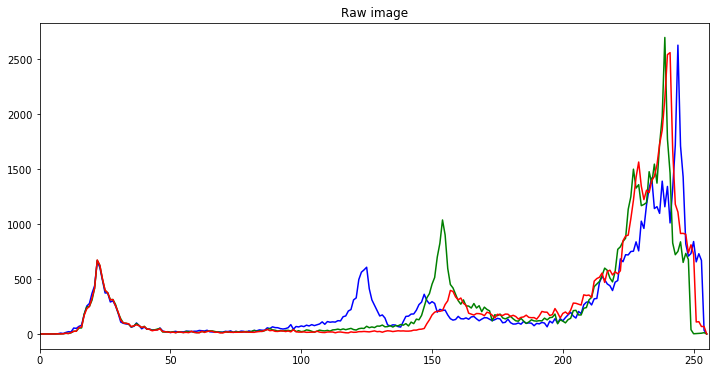

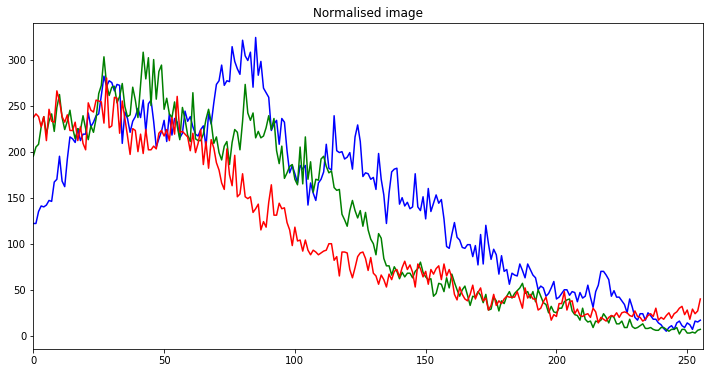

In [335]:
def draw_image_histogram(image, channels, title, color='k'):
    hist = cv2.calcHist([image], channels, None, [256], [0, 1])
    plt.plot(hist, color=color)
    plt.title(title)
    plt.xlim([0, 256])
    
def show_color_histogram(image, title):
    for i, col in enumerate(['b', 'g', 'r']):
        draw_image_histogram(image, [i], title, color=col)
        
"""
Load a basic preprocessed image without any normalization.
"""
img = cv2.imread(file_img_paths[25])
img_scaled = cv2.resize(img, (256, 256))
img_array = image.img_to_array(img_scaled) 
img_array = img_array.astype('float32')/255

img_norm = img_array.copy()
img_norm -= dataset_mean # center
img_norm /= dataset_std # normalize

# Visualise it
fig = plt.figure(figsize=(12, 12))
        
imgplt = fig.add_subplot(1, 2, 1)
imgplt.set_title("Raw Image")
plt.imshow(img_array)

imgplt = fig.add_subplot(1, 2, 2)
imgplt.set_title("Normalised image")
plt.imshow(orig_train_tensors[25])

fig = plt.figure(figsize=(12, 6))        
show_color_histogram(img_array, 'Raw image')

fig = plt.figure(figsize=(12, 6)) 
show_color_histogram(img_norm, 'Normalised image')

plt.show()   

### Enhancing Contrast
In the puisuit of better performance a few computer vision algorithms are tried for enhancing contrast with the hope of faster convergence and/or accuracy:
    - Histogram equalization
    - Contrast stretching


#### Histogram Equalization
Is a method that improves the contrast in an image, by stretching out the intensity range. It provides a sophisticated method for modifying the dynamic range and contrast of an image by altering that image such that its intensity histogram has a desired shape.
https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html

The code for performing histogram equalization is very easy for gray scale images. this can easily be done in OpenCV via a single method call *cv2.equalizeHist*. When doing it on color images with 3 input channels we need to tranform to a color space using a single channel for capturing the brightness/intensity/luminance of the input image and run the histogram equalization on that chennel. I have here used the YCbCr color space where Y is the luma component of the color. Luma component is the brightness of the color, the light intensity of the color. Other colorspaces one could consider to use would be LUV (L for luminance) or HSV (V for value/brightness).
https://medium.com/@danojadias/what-is-ycbcr-964fde85eeb3

Running histogram equalizatio on gray scale image (img):

    cv2.equalizeHist(img)

Running histogram equalizatio on color scale image (img):
    
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_YCrCb)
    y_eq_hist = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((y_eq_hist, cr, cb))
    img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)  


#### Contrast Stretching
Contrast stretching attempts to improve an image by stretching the range of intensity values it contains to make full use of possible values. Often done on almost all intensities that fall within a certain percentile range (ex. 2nd and 98th). Unlike histogram equalization, contrast stretching is restricted to a linear mapping of input to output values. The result is less dramatic, but tends to avoid the sometimes artificial appearance of equalized images.
https://homepages.inf.ed.ac.uk/rbf/HIPR2/stretch.htm

Running contrast stretching on gray scale and color images are the same. The following code approach analyzes the distribution of pixel densities in an image and then rescales the image to include all intensities that fall within the 10th and 90th percentiles.

    p10, p90 = np.percentile(img, (10, 90))
    exposure.rescale_intensity(img, in_range=(p10, p90))
    
   
The following script illustrates the effect of these techniques on gray and color images. Both the effect on the image itself and the associated image histogram are shown. Script also available in the repo (show_preprocessing_techniques.py).

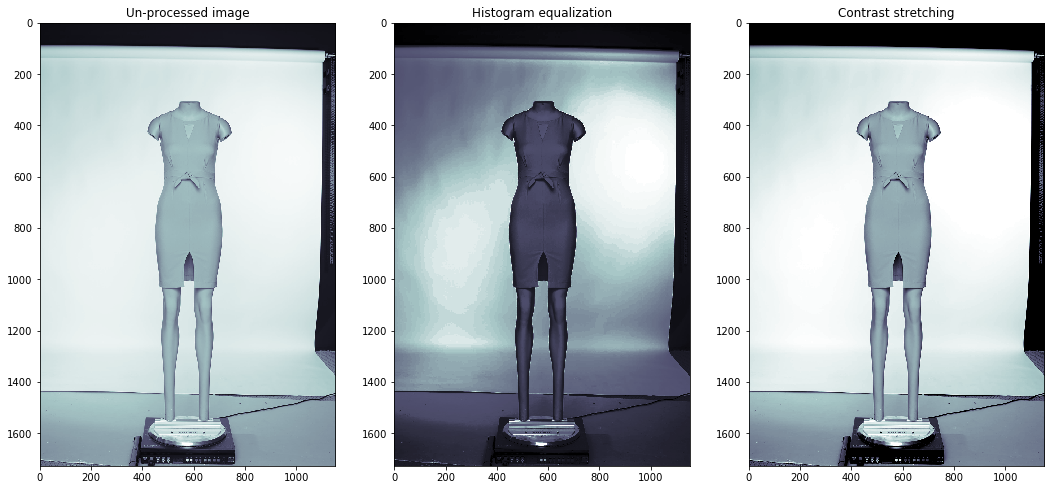

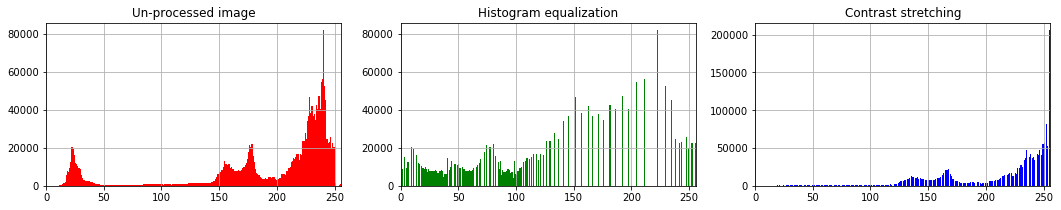

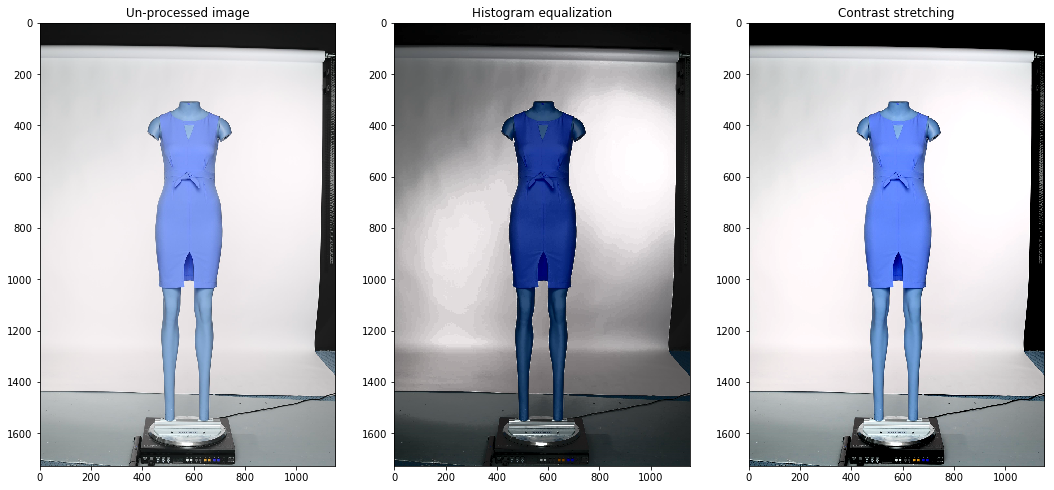

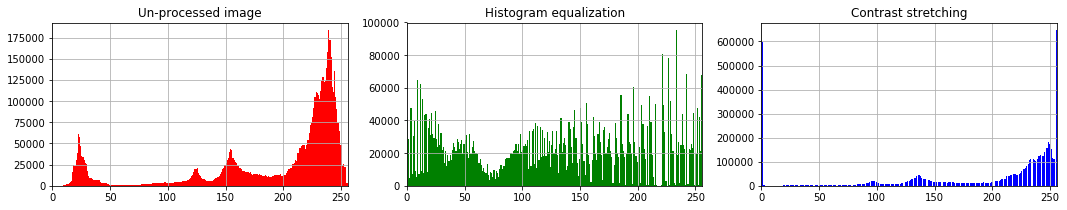

In [348]:
import copy

def show_contrast_effects(img_gray, img_color):    

#----------------------- Gray stuff ------------------

    eq_hist_img = copy.copy(img_gray)
    eq_hist_img = cv2.equalizeHist(eq_hist_img)

    contrast_strech_img = copy.copy(img_gray)
    p10, p90 = np.percentile(contrast_strech_img, (10, 90))
    contrast_strech_img  = exposure.rescale_intensity(contrast_strech_img, in_range=(p10, p90))


    fig = plt.figure(figsize=(18, 18))

    imgplt = fig.add_subplot(1, 3, 1)
    imgplt.set_title("Un-processed image")
    plt.imshow(img_gray, cmap=plt.cm.bone)
    
    imgplt = fig.add_subplot(1, 3, 2)
    imgplt.set_title("Histogram equalization")
    plt.imshow(eq_hist_img, cmap=plt.cm.bone)

    imgplt = fig.add_subplot(1, 3, 3)
    imgplt.set_title("Contrast stretching")
    plt.imshow(contrast_strech_img, cmap=plt.cm.bone)

    fig = plt.figure(figsize=(18, 3))

    imgplt = fig.add_subplot(1, 3, 1)
    imgplt.set_title("Un-processed image")
    plt.hist(img_gray.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.grid(True)
    
    imgplt = fig.add_subplot(1, 3, 2)
    imgplt.set_title("Histogram equalization")
    plt.hist(eq_hist_img.flatten(),256,[0,256], color = 'g')
    plt.xlim([0,256])
    plt.grid(True)
    
    imgplt = fig.add_subplot(1, 3, 3)
    imgplt.set_title("Contrast stretching")
    plt.hist(contrast_strech_img.flatten(),256,[0,256], color = 'b')
    plt.xlim([0,256])
    plt.grid(True)

#------------------Color stuff -------------------------------

    eq_hist_color_img = copy.copy(img_color)
    img_y_cr_cb = cv2.cvtColor(eq_hist_color_img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    y_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
    eq_hist_color_img = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)    

    contrast_strech_color_img = copy.copy(img_color)
    p10, p90 = np.percentile(contrast_strech_color_img, (10, 90))
    contrast_strech_color_img  = exposure.rescale_intensity(contrast_strech_color_img, in_range=(p10, p90))


    figcolor = plt.figure(figsize=(18, 18))

    imgplt = figcolor.add_subplot(1, 3, 1)
    imgplt.set_title("Un-processed image")
    plt.imshow(img_color)
    
    imgplt = figcolor.add_subplot(1, 3, 2)
    imgplt.set_title("Histogram equalization")
    plt.imshow(eq_hist_color_img)

    imgplt = figcolor.add_subplot(1, 3, 3)
    imgplt.set_title("Contrast stretching")
    plt.imshow(contrast_strech_color_img)

    fig = plt.figure(figsize=(18, 3))

    imgplt = fig.add_subplot(1, 3, 1)
    imgplt.set_title("Un-processed image")
    plt.hist(img_color.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.grid(True)
    
    imgplt = fig.add_subplot(1, 3, 2)
    imgplt.set_title("Histogram equalization")
    plt.hist(eq_hist_color_img.flatten(),256,[0,256], color = 'g')
    plt.xlim([0,256])
    plt.grid(True)
    
    imgplt = fig.add_subplot(1, 3, 3)
    imgplt.set_title("Contrast stretching")
    plt.hist(contrast_strech_color_img.flatten(),256,[0,256], color = 'b')
    plt.xlim([0,256])
    plt.grid(True)  


img_color = cv2.imread(file_img_paths[25])
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
show_contrast_effects(img_gray, img_color)
plt.show()

### Understanding and handling outliers
We will investigate outliers. The main reason is that the dataset have, for certain garments, some smaller defects, that is, our ground truth masks are not 100% accurate. In order to understand the outliers we first need to find them. For finding them we define outliers as anything lower of higher than 2 x standard deviation. We will use this on the outcome of the predictor itself, that is, the Dice score producted for a given file at full resolution.

Code snippet from calculate_outliers.py:

    score_mean = np.mean(dice_values)
    score_std = np.std(dice_values)
    
    outlier_list = []
    final_score_list = []
    
    if ((dice_score > (score_mean - 2 * score_std)) and (dice_score < (score_mean + 2 * score_std))):
        final_score_list.append(item)
    else:
        outlier_list.append(item)
